# Set-Up

In [1]:
import jax
import jax.numpy as jnp
from approx_post import losses, optimisers, distributions
import seaborn as sns
import matplotlib.pyplot as plt
from arraytainers import Jaxtainer
sns.set({'figure.facecolor':'white', "figure.figsize":(10,7)})

# Plotting Functions

In [2]:
def plot_data(data, true_theta, model):
    sns.scatterplot(x=true_theta.squeeze(), y=data.squeeze(), label=f"Obsevations")
    sns.lineplot(x=true_theta.squeeze(), y=model(true_theta).squeeze(), label=f"True Relationship", color='r')
    plt.xlabel("Parameter $\Theta$")
    plt.ylabel("(Noisy) Observations $x$")
    plt.show()

In [3]:
def plot_phi_function(amortised_dist, x, x_obs=None, true_theta=None, model=None):
    if x.ndim < 2:
        x = x[:,None]
    pred_phi = amortised_dist.phi(x)
    pred_mean, pred_cov = pred_phi['mean'].squeeze(), jnp.exp(pred_phi['log_chol_diag']).squeeze()**2
    mean_plus_cov = pred_mean + pred_cov
    mean_minus_cov = pred_mean - pred_cov
    
    x_plt = x.squeeze()
    ax = sns.lineplot(x=x_plt, y=pred_mean, label=f"Predicted Mean", color='red')
    sns.lineplot(x=x_plt, y=mean_plus_cov, color='red', label=f"Predicted Mean Plus/Minus Predicted Variance", linestyle='--')
    sns.lineplot(x=x_plt, y=mean_minus_cov, color='red', linestyle='--')
    ax.fill_between(x_plt, mean_minus_cov, mean_plus_cov, color="red", alpha=0.2)
    if (data is not None) and (true_theta is not None):
        sns.scatterplot(x=data.squeeze(), y=true_theta.squeeze(), label=f"Observations") 
    if (model is not None) and (true_theta is not None):
        sns.scatterplot(x=model(true_theta.squeeze()), y=true_theta.squeeze(), label=f"True Relationship", color='g')
    plt.xlabel("Observation $x$")
    plt.ylabel("Parameter $\Theta$")
    plt.show()

In [4]:
def plot_posteriors(ammortised_dist, x_list, theta=None):
    if theta is None:
        theta = jnp.atleast_2d(jnp.linspace(-3, 3, 1000)).reshape(1,-1,1)
    for x_i in x_list:
        pdf = jnp.exp(amortised_dist.logpdf(theta, x=jnp.array([[x_i]])))
        ax = sns.lineplot(x=theta.squeeze(), y=pdf.squeeze(), label=f"x = {x_i:.1f}")
        ax.fill_between(theta.squeeze(), pdf.squeeze(), alpha=0.2)
    plt.xlabel("Parameter $\Theta$")
    plt.ylabel("Posterior Probability Density")

# Artificial Data Creation

In [5]:
def create_data(model, theta, noise_cov, prngkey):
    num_batch = theta.shape[0] 
    mean_vals = model(theta).reshape(num_batch, -1) # shape = (num_batch, dim_theta)
    # Zero-mean samples:
    x_dim = mean_vals.shape[1]
    epsilon = jax.random.multivariate_normal(prngkey, mean=jnp.zeros(x_dim), cov=noise_cov, shape=(num_batch,)) # shape = (num_batch, dim_x)
    # Add each mean on:
    samples = mean_vals + epsilon # shape = (num_batch, x_dim)
    return samples

In [6]:
# Define model:
ndim = 1
model = lambda theta: theta**2
model_grad = jax.vmap(jax.vmap(jax.jacfwd(model), in_axes=0), in_axes=0)

In [7]:
prngkey = jax.random.PRNGKey(42)
num_batch = 100
true_theta = jnp.linspace(-5, 5, 100)
num_batch = 100
noise_cov = 1*jnp.identity(ndim)
data = create_data(model, true_theta, noise_cov, prngkey)

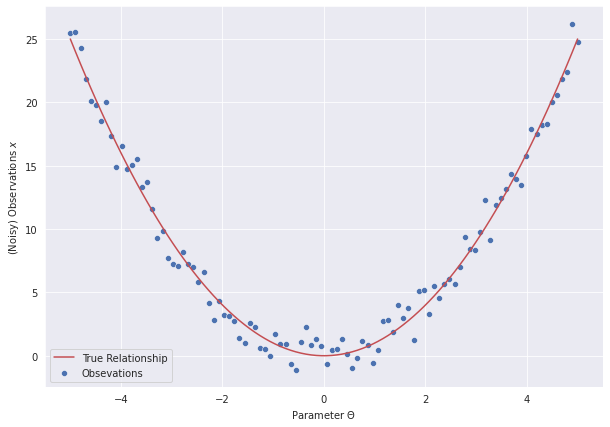

In [8]:
plot_data(data, true_theta, model)

# Create Joint Distribution

In [9]:
# Create Joint distribution from forward model:
prior_mean = jnp.zeros(ndim)
prior_cov = jnp.identity(ndim)
noise_cov = jnp.identity(ndim)
joint_dist = distributions.joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)

# Neural Network

In [11]:
prngkey = jax.random.PRNGKey(10)
approx_dist = distributions.approx.Gaussian(ndim)
mix_dict = distributions.mixture.Identical(approx_dist,2)
preprocessing = distributions.amortised.Preprocessing.std_scaling(data)
amortised_dist = distributions.amortised.NeuralNetwork(approx_dist, ndim, prngkey, num_layers=3, width=10, \
                                                       activation='sigmoid', preprocessing=preprocessing)

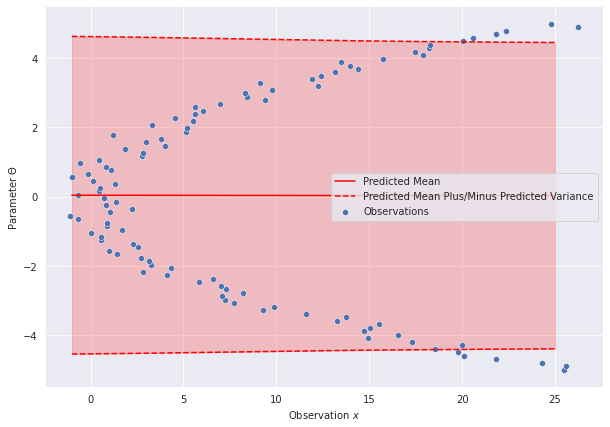

In [12]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [ ]:
# Initialise:
target = Jaxtainer({'mean': 0*data, 'log_chol_diag': jnp.zeros(data.shape)})
mse = losses.MSE(target)
optimiser = optimisers.Adam(lr=1e-3)
optimiser.fit(amortised_dist, mse, data, prngkey, verbose=True)

Loss = 57.076236724853516, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7142209 , -0.4080591 ,  1.7485319 , -0.7388631 ,
              -2.1461651 ,  0.62445015, -0.19286647, -0.24542642,
               1.3260455 , -0.35811827]], dtype=float32), 'b_0': DeviceArray([ 0.001     ,  0.001     , -0.00099997,  0.001     ,
             -0.00099999,  0.001     , -0.001     , -0.00099999,
              0.00099998,  0.00099998], dtype=float32), 'W_1': DeviceArray([[ 0.11159218,  0.04624535, -0.5942347 , -0.3922987 ,
               0.58711016, -0.53313655, -0.42155606,  0.5889025 ,
               0.36849067, -0.61434954],
             [ 0.0196183 , -0.9800631 , -0.14171357,  0.761651  ,
              -0.7295886 , -0.3673932 ,  0.12658593,  0.13162214,
              -0.04866989,  0.6975727 ],
             [-0.14747468,  0.30980226,  0.02458243, -0.75604457,
              -0.19593774, -0.49778664,  0.2381489 ,  0.03369565,
              -0.02963164, -0.12136951],
             [ 0.5131931 ,  0.1444092

Loss = 50.895450592041016, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7112231 , -0.40506297,  1.7515413 , -0.74186194,
              -2.1431718 ,  0.6214537 , -0.18986224, -0.24243023,
               1.3230397 , -0.36110115]], dtype=float32), 'b_0': DeviceArray([ 0.00399473,  0.00400103, -0.00401061,  0.00399826,
             -0.00399093,  0.00399522, -0.00399368, -0.00398534,
              0.00400902,  0.00392201], dtype=float32), 'W_1': DeviceArray([[ 0.1145881 ,  0.04324837, -0.5972298 , -0.39526257,
               0.5901076 , -0.53608674, -0.41854447,  0.5919007 ,
               0.365497  , -0.6173611 ],
             [ 0.0226143 , -0.98305994, -0.14470868,  0.75868607,
              -0.7265913 , -0.37033752,  0.12959754,  0.13462034,
              -0.05166359,  0.6945618 ],
             [-0.14447907,  0.30680543,  0.02158773, -0.7590072 ,
              -0.19294043, -0.50073946,  0.24116029,  0.03669368,
              -0.03262509, -0.12438084],
             [ 0.51618916,  0.1414124

Loss = 47.07904052734375, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7092285 , -0.40307155,  1.7535663 , -0.743859  ,
              -2.1411872 ,  0.61946183, -0.18785329, -0.24043891,
               1.321027  , -0.3630616 ]], dtype=float32), 'b_0': DeviceArray([ 0.00598262,  0.00600262, -0.00603259,  0.005994  ,
             -0.00597018,  0.00598425, -0.00597924, -0.00595149,
              0.00602771,  0.00571656], dtype=float32), 'W_1': DeviceArray([[ 0.11657861,  0.04125562, -0.59921825, -0.39717504,
               0.59210175, -0.53796136, -0.41651866,  0.59389627,
               0.3635114 , -0.6193862 ],
             [ 0.02460502, -0.9850524 , -0.14669733,  0.7567709 ,
              -0.72459733, -0.3721952 ,  0.13162282,  0.13661583,
              -0.05364919,  0.6925359 ],
             [-0.14248924,  0.30481294,  0.01960002, -0.7609167 ,
              -0.19094665, -0.5026219 ,  0.24318624,  0.03868876,
              -0.03461009, -0.12640463],
             [ 0.51817995,  0.13942009

Loss = 43.46717834472656, Params = Jaxtainer({'W_0': DeviceArray([[ 0.70723933, -0.40108755,  1.7556112 , -0.7458529 ,
              -2.139217  ,  0.61747706, -0.18583867, -0.23845503,
               1.3190056 , -0.36498886]], dtype=float32), 'b_0': DeviceArray([ 0.00795979,  0.00800276, -0.00806738,  0.00798563,
             -0.0079307 ,  0.00796353, -0.00795228, -0.00788864,
              0.00805872,  0.00731213], dtype=float32), 'W_1': DeviceArray([[ 0.11856029,  0.03927057, -0.6011957 , -0.3990107 ,
               0.5940915 , -0.5397136 , -0.41447333,  0.59588677,
               0.36153856, -0.6214281 ],
             [ 0.0265871 , -0.987037  , -0.14867513,  0.7549299 ,
              -0.7226079 , -0.37391004,  0.13366663,  0.13860619,
              -0.0556221 ,  0.69049054],
             [-0.14050885,  0.3028284 ,  0.01762396, -0.76274663,
              -0.18895762, -0.5043916 ,  0.24523218,  0.0406783 ,
              -0.03658187, -0.1284435 ],
             [ 0.52016217,  0.13743573

Loss = 40.02655792236328, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7052578 , -0.39911312,  1.7576704 , -0.7478421 ,
              -2.1372662 ,  0.61550105, -0.18381935, -0.23647998,
               1.3169752 , -0.36687902]], dtype=float32), 'b_0': DeviceArray([ 0.0099233 ,  0.00999659, -0.01010898,  0.00997174,
             -0.0098663 ,  0.00993017, -0.0099097 , -0.00979114,
              0.01010097,  0.00869446], dtype=float32), 'W_1': DeviceArray([[ 0.1205299 ,  0.03729758, -0.6031575 , -0.40076178,
               0.5960772 , -0.5413131 , -0.41240788,  0.5978691 ,
               0.35958213, -0.6234833 ],
             [ 0.02855737, -0.9890093 , -0.15063755,  0.75317025,
              -0.7206227 , -0.3754435 ,  0.13572942,  0.14058842,
              -0.05757863,  0.68842846],
             [-0.13854133,  0.3008563 ,  0.01566438, -0.7644888 ,
              -0.18697299, -0.5060221 ,  0.24729867,  0.04265909,
              -0.0385366 , -0.13049348],
             [ 0.5221327 ,  0.13546373

Loss = 36.751773834228516, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7032861 , -0.39715052,  1.7597297 , -0.7498248 ,
              -2.1353407 ,  0.6135354 , -0.18179744, -0.2345148 ,
               1.3149369 , -0.36873227]], dtype=float32), 'b_0': DeviceArray([ 0.01187036,  0.01197734, -0.0121463 ,  0.01195083,
             -0.01177065,  0.01188136, -0.01184869, -0.01165532,
              0.0121515 ,  0.00989865], dtype=float32), 'W_1': DeviceArray([[ 0.12248398,  0.03534181, -0.6050986 , -0.40243286,
               0.5980599 , -0.5427424 , -0.4103244 ,  0.5998396 ,
               0.35764563, -0.6255438 ],
             [ 0.03051244, -0.9909643 , -0.15257952,  0.7514874 ,
              -0.71864086, -0.37677273,  0.13780916,  0.1425589 ,
              -0.05951526,  0.6863576 ],
             [-0.13659032,  0.29890192,  0.01372655, -0.7661475 ,
              -0.18499193, -0.50749886,  0.24938346,  0.04462728,
              -0.0404706 , -0.13254632],
             [ 0.52408814,  0.1335092

Loss = 33.64818572998047, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7013269 , -0.3952022 ,  1.761769  , -0.75179905,
              -2.1334462 ,  0.6115816 , -0.17977583, -0.23256044,
               1.3128922 , -0.3705512 ]], dtype=float32), 'b_0': DeviceArray([ 0.01379826,  0.01393739, -0.01416527,  0.0139212 ,
             -0.0136375 ,  0.01381432, -0.01376664, -0.01347856,
              0.01420625,  0.01098727], dtype=float32), 'W_1': DeviceArray([[ 1.2441898e-01,  3.3408757e-02, -6.0701370e-01,
              -4.0403527e-01,  6.0004032e-01, -5.4399437e-01,
              -4.0822649e-01,  6.0179442e-01,  3.5573250e-01,
              -6.2759870e-01],
             [ 3.2448847e-02, -9.9289644e-01, -1.5449584e-01,
               7.4987000e-01, -7.1666157e-01, -3.7788796e-01,
               1.3990246e-01,  1.4451374e-01, -6.1428592e-02,
               6.8428904e-01],
             [-1.3465953e-01,  2.9697087e-01,  1.1815902e-02,
              -7.6773405e-01, -1.8301365e-01, -5.0881654e-01,

Loss = 30.72077751159668, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6993829 , -0.3932709 ,  1.7637649 , -0.75376254,
              -2.1315887 ,  0.60964125, -0.17775793, -0.23061807,
               1.3108435 , -0.3723396 ]], dtype=float32), 'b_0': DeviceArray([ 0.01570428,  0.01586886, -0.01615026,  0.01588091,
             -0.01546084,  0.01572624, -0.01566092, -0.01525873,
              0.01626069,  0.01203215], dtype=float32), 'W_1': DeviceArray([[ 0.12633134,  0.03150396, -0.6088976 , -0.40558344,
               0.602019  , -0.5450696 , -0.40611854,  0.60372937,
               0.35384604, -0.629636  ],
             [ 0.03436306, -0.9948002 , -0.15638135,  0.7483043 ,
              -0.7146844 , -0.37878957,  0.14200519,  0.1464489 ,
              -0.06331535,  0.6822353 ],
             [-0.1327527 ,  0.2950688 ,  0.00993777, -0.769263  ,
              -0.18103778, -0.50997627,  0.25359172,  0.04850923,
              -0.04426249, -0.1366166 ],
             [ 0.52793986,  0.12967458

Loss = 27.971900939941406, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6974569 , -0.3913597 ,  1.7656914 , -0.7557127 ,
              -2.1297736 ,  0.60771614, -0.17574751, -0.22868909,
               1.3087931 , -0.37410176]], dtype=float32), 'b_0': DeviceArray([ 0.01758569,  0.01776404, -0.01808514,  0.01782778,
             -0.01723499,  0.01761435, -0.01752892, -0.01699391,
              0.01831006,  0.01310202], dtype=float32), 'W_1': DeviceArray([[ 0.12821752,  0.02963275, -0.6107454 , -0.40709218,
               0.6039958 , -0.54597396, -0.40400517,  0.60564035,
               0.3519894 , -0.631643  ],
             [ 0.0362516 , -0.9966704 , -0.1582311 ,  0.7467759 ,
              -0.71270955, -0.3794853 ,  0.14411293,  0.14836028,
              -0.06517239,  0.68020976],
             [-0.13087349,  0.29320115,  0.00809725, -0.77074945,
              -0.17906451, -0.5109838 ,  0.25570557,  0.0504145 ,
              -0.04611372, -0.13860974],
             [ 0.5298292 ,  0.1278051

Loss = 25.40110969543457, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6955518 , -0.38947177,  1.7675222 , -0.7576467 ,
              -2.1280062 ,  0.6058082 , -0.1737486 , -0.22677524,
               1.3067439 , -0.37584174]], dtype=float32), 'b_0': DeviceArray([ 0.01943976,  0.01961577, -0.01995417,  0.01975936,
             -0.01895474,  0.01947587, -0.01936796, -0.01868219,
              0.0203496 ,  0.01425313], dtype=float32), 'W_1': DeviceArray([[ 0.13007405,  0.02780013, -0.61255234, -0.4085748 ,
               0.60596997, -0.5467165 , -0.40189108,  0.6075234 ,
               0.35016555, -0.63360715],
             [ 0.03811104, -0.99850214, -0.16004045,  0.7452719 ,
              -0.71073765, -0.37998736,  0.1462212 ,  0.15024392,
              -0.06699669,  0.6782256 ],
             [-0.12902544,  0.29137298,  0.00629908, -0.77220684,
              -0.17709461, -0.51184726,  0.2578193 ,  0.0522904 ,
              -0.04793096, -0.14055862],
             [ 0.5316897 ,  0.12597442

Loss = 23.00530433654785, Params = Jaxtainer({'W_0': DeviceArray([[ 0.69367075, -0.38761055,  1.7692324 , -0.75956154,
              -2.126291  ,  0.6039195 , -0.17176522, -0.2248786 ,
               1.3046987 , -0.37756297]], dtype=float32), 'b_0': DeviceArray([ 0.02126369,  0.02141775, -0.02174322,  0.02167301,
             -0.02061543,  0.02130806, -0.02117534, -0.02032142,
              0.02237486,  0.01552287], dtype=float32), 'W_1': DeviceArray([[ 0.13189766,  0.0260106 , -0.6143143 , -0.4100416 ,
               0.6079401 , -0.54730695, -0.3997807 ,  0.6093745 ,
               0.34837744, -0.635517  ],
             [ 0.03993809, -1.0002909 , -0.16180523,  0.7437826 ,
              -0.7087702 , -0.3803092 ,  0.14832574,  0.15209602,
              -0.06878538,  0.676295  ],
             [-0.12721196,  0.28958887,  0.0045475 , -0.77364564,
              -0.17512955, -0.51257515,  0.25992823,  0.05413305,
              -0.0497113 , -0.1424521 ],
             [ 0.5335181 ,  0.12418675

Loss = 20.779273986816406, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6918166 , -0.38577956,  1.7708007 , -0.7614542 ,
              -2.1246324 ,  0.6020524 , -0.16980131, -0.22300163,
               1.3026608 , -0.37926748]], dtype=float32), 'b_0': DeviceArray([ 0.0230547 ,  0.02316498, -0.02344098,  0.02356591,
             -0.02221306,  0.02310821, -0.02294827, -0.02190909,
              0.02438185,  0.01692764], dtype=float32), 'W_1': DeviceArray([[ 0.1336852 ,  0.024268  , -0.61602765, -0.41149867,
               0.609904  , -0.5477535 , -0.39767805,  0.6111904 ,
               0.34662777, -0.63736284],
             [ 0.04172965, -1.0020328 , -0.16352178,  0.74230206,
              -0.7068094 , -0.3804629 ,  0.15042268,  0.15391304,
              -0.07053574,  0.67442816],
             [-0.12543617,  0.2878527 ,  0.00284616, -0.77507216,
              -0.17317152, -0.51317436,  0.2620282 ,  0.05593888,
              -0.05145195, -0.14428093],
             [ 0.5353112 ,  0.1224459

Loss = 17.744070053100586, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6890927 , -0.38309744,  1.7728578 , -0.7642449 ,
              -2.1222572 ,  0.5992975 , -0.16689976, -0.22022954,
               1.299624  , -0.38179317]], dtype=float32), 'b_0': DeviceArray([ 0.02567331,  0.02567609, -0.02580185,  0.02635979,
             -0.02448424,  0.02574254, -0.02553685, -0.02418708,
              0.02735111,  0.01927893], dtype=float32), 'W_1': DeviceArray([[ 1.36292651e-01,  2.17486341e-02, -6.18499994e-01,
              -4.13667023e-01,  6.12831712e-01, -5.48163295e-01,
              -3.94545913e-01,  6.13841176e-01,  3.44081074e-01,
              -6.39997303e-01],
             [ 4.43441831e-02, -1.00455129e+00, -1.65999770e-01,
               7.40097165e-01, -7.03886986e-01, -3.80395830e-01,
               1.53546676e-01,  1.56566054e-01, -7.30836987e-02,
               6.71762705e-01],
             [-1.22849450e-01,  2.85344809e-01,  3.94688919e-04,
              -7.77190089e-01, -1.702

Loss = 15.91302490234375, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6873193 , -0.38135737,  1.774027  , -0.7660686 ,
              -2.1207528 ,  0.5974954 , -0.16499938, -0.21841522,
               1.2976168 , -0.38345337]], dtype=float32), 'b_0': DeviceArray([ 0.0273697 ,  0.02727509, -0.02725001,  0.02818757,
             -0.02591138,  0.02745106, -0.02721115, -0.0256313 ,
              0.02929975,  0.02098237], dtype=float32), 'W_1': DeviceArray([[ 0.13797802,  0.02013507, -0.62008   , -0.4150937 ,
               0.6147658 , -0.5482627 , -0.39247614,  0.61555606,
               0.34243876, -0.64165986],
             [ 0.04603494, -1.0061644 , -0.16758402,  0.73864514,
              -0.7019569 , -0.38015714,  0.1556113 ,  0.1582827 ,
              -0.07472704,  0.67008   ],
             [-0.12117993,  0.28374004, -0.00116952, -0.7785801 ,
              -0.16832842, -0.5141245 ,  0.26721725,  0.0602731 ,
              -0.05561303, -0.1485341 ],
             [ 0.53962153,  0.11831729

Loss = 14.22819995880127, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6855833 , -0.3796595 ,  1.7750417 , -0.76785934,
              -2.1193135 ,  0.5957239 , -0.16312909, -0.21663213,
               1.2956266 , -0.38509014]], dtype=float32), 'b_0': DeviceArray([ 0.02902341,  0.02881458, -0.02860211,  0.02998387,
             -0.02726713,  0.02911852, -0.02884098, -0.02701115,
              0.03122188,  0.02276382], dtype=float32), 'W_1': DeviceArray([[ 0.13961844,  0.01857572, -0.6216037 , -0.41649386,
               0.61668056, -0.54821813, -0.3904234 ,  0.6172268 ,
               0.34084356, -0.64324826],
             [ 0.04768125, -1.0077235 , -0.16911235,  0.73721856,
              -0.70004654, -0.37976214,  0.15765911,  0.15995532,
              -0.07632343,  0.66847163],
             [-0.1195569 ,  0.28219038, -0.00267604, -0.7799412 ,
              -0.16642278, -0.514278  ,  0.2692623 ,  0.06192877,
              -0.05719501, -0.1501046 ],
             [ 0.5412704 ,  0.11675953

Loss = 12.683280944824219, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6838874 , -0.37800682,  1.7759155 , -0.7696144 ,
              -2.1179402 ,  0.593986  , -0.1612909 , -0.214884  ,
               1.293656  , -0.3866984 ]], dtype=float32), 'b_0': DeviceArray([ 0.03063182,  0.0302964 , -0.02986597,  0.03174565,
             -0.02855072,  0.03074262, -0.03042363, -0.02832241,
              0.0331165 ,  0.02459399], dtype=float32), 'W_1': DeviceArray([[ 0.14121203,  0.01707106, -0.62307036, -0.41785476,
               0.6185711 , -0.5480237 , -0.38838938,  0.6188518 ,
               0.33929756, -0.6447661 ],
             [ 0.04928118, -1.0092278 , -0.17058392,  0.73582983,
              -0.6981606 , -0.37920833,  0.15968832,  0.16158235,
              -0.0778708 ,  0.66693383],
             [-0.11798218,  0.2806962 , -0.00412418, -0.7812606 ,
              -0.16454232, -0.5142926 ,  0.27128726,  0.06353745,
              -0.05872668, -0.15160395],
             [ 0.5428731 ,  0.1152564

Loss = 11.271835327148438, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6822342 , -0.37640193,  1.7766658 , -0.77133113,
              -2.1166332 ,  0.5922841 , -0.15948644, -0.21317445,
               1.2917073 , -0.38827276]], dtype=float32), 'b_0': DeviceArray([ 0.03219255,  0.03172303, -0.03105127,  0.03346995,
             -0.02976203,  0.03232121, -0.03195659, -0.02956126,
              0.0349827 ,  0.02644444], dtype=float32), 'W_1': DeviceArray([[ 0.14275716,  0.01562115, -0.62447953, -0.41916287,
               0.62043244, -0.5476744 , -0.3863758 ,  0.6204298 ,
               0.33780262, -0.64621806],
             [ 0.05083308, -1.0106775 , -0.17199829,  0.7344921 ,
              -0.6963041 , -0.37849456,  0.16169715,  0.1631625 ,
              -0.07936727,  0.6654614 ],
             [-0.11645729,  0.2792575 , -0.00551367, -0.78252476,
              -0.162692  , -0.5141622 ,  0.2732904 ,  0.06509801,
              -0.06020625, -0.15303665],
             [ 0.54442805,  0.1138081

Loss = 9.986928939819336, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6806259 , -0.37484708,  1.7773103 , -0.77300704,
              -2.1153922 ,  0.59062064, -0.15771724, -0.21150678,
               1.2897834 , -0.38980833]], dtype=float32), 'b_0': DeviceArray([ 0.03370347,  0.03309705, -0.03216777,  0.03515401,
             -0.0309015 ,  0.03385243, -0.0334377 , -0.03072463,
              0.03681942,  0.02829005], dtype=float32), 'W_1': DeviceArray([[ 0.14425242,  0.01422579, -0.6258312 , -0.42040572,
               0.6222598 , -0.5471687 , -0.38438475,  0.6219599 ,
               0.33636034, -0.64760894],
             [ 0.05233549, -1.0120726 , -0.17335536,  0.7332175 ,
              -0.6944817 , -0.3776234 ,  0.1636835 ,  0.16469468,
              -0.08081126,  0.6640493 ],
             [-0.11498351,  0.27787396, -0.00684456, -0.7837213 ,
              -0.16087656, -0.51388335,  0.27526972,  0.06660954,
              -0.0616322 , -0.15440726],
             [ 0.54593384,  0.11241439

Loss = 8.821097373962402, Params = Jaxtainer({'W_0': DeviceArray([[ 0.67906445, -0.3733441 ,  1.7778642 , -0.7746399 ,
              -2.1142168 ,  0.58899784, -0.15598476, -0.20988388,
               1.2878869 , -0.39130142]], dtype=float32), 'b_0': DeviceArray([ 0.03516282,  0.03442066, -0.03322385,  0.03679527,
             -0.03197006,  0.03533463, -0.03486517, -0.03181059,
              0.03862513,  0.03011111], dtype=float32), 'W_1': DeviceArray([[ 0.14569665,  0.01288474, -0.6271254 , -0.4215736 ,
               0.6240488 , -0.54651004, -0.38241872,  0.62344104,
               0.33497196, -0.6489425 ],
             [ 0.0537872 , -1.0134133 , -0.17465521,  0.7320153 ,
              -0.69269764, -0.3766026 ,  0.16564482,  0.1661779 ,
              -0.08220156,  0.6626936 ],
             [-0.11356188,  0.27654526, -0.00811713, -0.78484064,
              -0.15910034, -0.5134575 ,  0.27722275,  0.06807121,
              -0.06300339, -0.15571944],
             [ 0.54738915,  0.11107506

Loss = 7.766541004180908, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6775515 , -0.3718943 ,  1.7783386 , -0.77622783,
              -2.113106  ,  0.5874175 , -0.15429056, -0.20830807,
               1.286021  , -0.39275005]], dtype=float32), 'b_0': DeviceArray([ 0.03656921,  0.03569536, -0.03422543,  0.03839141,
             -0.03296906,  0.03676649, -0.03623771, -0.03281851,
              0.04039773,  0.0318947 ], dtype=float32), 'W_1': DeviceArray([[ 0.14708887,  0.01159781, -0.6283624 , -0.4226608 ,
               0.6257958 , -0.54570764, -0.38048092,  0.6248723 ,
               0.33363837, -0.65022075],
             [ 0.05518719, -1.0146998 , -0.17589806,  0.7308912 ,
              -0.6909557 , -0.3754452 ,  0.16757795,  0.1676112 ,
              -0.0835373 ,  0.6613923 ],
             [-0.11219325,  0.27527112, -0.00933176, -0.7858771 ,
              -0.15736708, -0.5128913 ,  0.2791464 ,  0.0694822 ,
              -0.06431905, -0.15697533],
             [ 0.5487931 ,  0.10978993

Loss = 6.815513610839844, Params = Jaxtainer({'W_0': DeviceArray([[ 0.67608845, -0.3704986 ,  1.778739  , -0.77776897,
              -2.1120589 ,  0.58588105, -0.15263635, -0.20678112,
               1.284189  , -0.39415422]], dtype=float32), 'b_0': DeviceArray([ 0.03792164,  0.03692176, -0.03517556,  0.03994039,
             -0.0339002 ,  0.03814697, -0.03755443, -0.03374922,
              0.04213447,  0.03363518], dtype=float32), 'W_1': DeviceArray([[ 0.14842829,  0.01036493, -0.6295426 , -0.423666  ,
               0.62749755, -0.544776  , -0.37857512,  0.62625283,
               0.33236   , -0.65144384],
             [ 0.05653461, -1.0159322 , -0.17708416,  0.7298464 ,
              -0.6892588 , -0.37416902,  0.16947918,  0.1689936 ,
              -0.08481801,  0.66014546],
             [-0.11087827,  0.27405137, -0.0104889 , -0.7868296 ,
              -0.15567982, -0.5121967 ,  0.2810369 ,  0.07084171,
              -0.06557878, -0.15817522],
             [ 0.5501446 ,  0.10855893

Loss = 5.960572719573975, Params = Jaxtainer({'W_0': DeviceArray([[ 0.67467624, -0.36915743,  1.7790663 , -0.7792618 ,
              -2.111074  ,  0.58438957, -0.15102398, -0.2053042 ,
               1.2823942 , -0.39551562]], dtype=float32), 'b_0': DeviceArray([ 0.03921951,  0.03809967, -0.03607453,  0.04144045,
             -0.03476547,  0.03947534, -0.03881493, -0.03460481,
              0.04383209,  0.03533338], dtype=float32), 'W_1': DeviceArray([[ 0.14971429,  0.00918613, -0.63066626, -0.4245922 ,
               0.6291518 , -0.54373384, -0.37670556,  0.6275815 ,
               0.33113703, -0.6526099 ],
             [ 0.05782883, -1.0171105 , -0.17821383,  0.728878  ,
              -0.6876094 , -0.37279522,  0.17134432,  0.17032416,
              -0.08604354,  0.65895563],
             [-0.10961743,  0.27288598, -0.01158907, -0.7877013 ,
              -0.15404098, -0.5113899 ,  0.28289002,  0.07214889,
              -0.06678255, -0.15931773],
             [ 0.5514432 ,  0.10738207

Loss = 5.194667339324951, Params = Jaxtainer({'W_0': DeviceArray([[ 0.67331564, -0.36787084,  1.7793175 , -0.7807051 ,
              -2.11015   ,  0.58294386, -0.14945535, -0.20387803,
               1.2806402 , -0.39683747]], dtype=float32), 'b_0': DeviceArray([ 0.04046255,  0.03922828, -0.03692059,  0.04289005,
             -0.03556715,  0.04075112, -0.0400192 , -0.03538845,
              0.04548696,  0.03699496], dtype=float32), 'W_1': DeviceArray([[ 0.15094644,  0.00806151, -0.6317338 , -0.42544574,
               0.6307566 , -0.542602  , -0.37487677,  0.62885743,
               0.3299693 , -0.6537158 ],
             [ 0.05906937, -1.0182346 , -0.17928748,  0.7279799 ,
              -0.68600917, -0.37134662,  0.17316896,  0.17160194,
              -0.08721413,  0.6578265 ],
             [-0.10841099,  0.2717749 , -0.01263286, -0.78849876,
              -0.1524523 , -0.5104898 ,  0.28470126,  0.07340297,
              -0.06793065, -0.16040032],
             [ 0.5526883 ,  0.10625941

Loss = 4.511063098907471, Params = Jaxtainer({'W_0': DeviceArray([[ 0.67200714, -0.36663845,  1.7794875 , -0.7820978 ,
              -2.1092856 ,  0.5815444 , -0.14793225, -0.20250297,
               1.2789307 , -0.39812377]], dtype=float32), 'b_0': DeviceArray([ 0.04165081,  0.04030649, -0.03771085,  0.04428794,
             -0.03630771,  0.04197407, -0.04116755, -0.03610405,
              0.04709538,  0.03862797], dtype=float32), 'W_1': DeviceArray([[ 0.1521245 ,  0.0069911 , -0.6327458 , -0.42623496,
               0.6323106 , -0.5414023 , -0.37309328,  0.6300799 ,
               0.32885626, -0.65475786],
             [ 0.06025596, -1.0193044 , -0.18030562,  0.72714394,
              -0.68445945, -0.36984605,  0.17494868,  0.17282616,
              -0.08833023,  0.6567625 ],
             [-0.10725904,  0.27071813, -0.01362099, -0.7892304 ,
              -0.15091515, -0.50951636,  0.28646612,  0.07460328,
              -0.06902366, -0.16141994],
             [ 0.5538797 ,  0.10519095

Loss = 3.9032349586486816, Params = Jaxtainer({'W_0': DeviceArray([[ 0.67075086, -0.3654595 ,  1.7795715 , -0.7834391 ,
              -2.1084788 ,  0.5801916 , -0.14645618, -0.20117909,
               1.2772688 , -0.3993786 ]], dtype=float32), 'b_0': DeviceArray([ 0.04278455,  0.04133324, -0.03844239,  0.0456331 ,
             -0.03698983,  0.04314417, -0.04226053, -0.0367559 ,
              0.04865384,  0.04024044], dtype=float32), 'W_1': DeviceArray([[ 0.15324846,  0.00597475, -0.63370305, -0.42696878,
               0.6338128 , -0.5401555 , -0.37135935,  0.6312484 ,
               0.32779726, -0.65573275],
             [ 0.06138856, -1.0203202 , -0.18126896,  0.72636163,
              -0.68296134, -0.36831483,  0.17667928,  0.17399625,
              -0.08939255,  0.6557678 ],
             [-0.10616146,  0.26971546, -0.01455434, -0.78990525,
              -0.14943054, -0.5084889 ,  0.28818038,  0.07574937,
              -0.07006235, -0.16237384],
             [ 0.5550172 ,  0.1041765

Loss = 3.3648018836975098, Params = Jaxtainer({'W_0': DeviceArray([[ 0.66954684, -0.36433294,  1.7795662 , -0.78472847,
              -2.1077278 ,  0.5788856 , -0.14502828, -0.19990636,
               1.2756574 , -0.40060568]], dtype=float32), 'b_0': DeviceArray([ 0.04386422,  0.04230787, -0.03911326,  0.04692471,
             -0.03761636,  0.04426158, -0.04329887, -0.03734833,
              0.05015929,  0.04183817], dtype=float32), 'W_1': DeviceArray([[ 0.15431853,  0.00501206, -0.6346065 , -0.4276552 ,
               0.6352621 , -0.5388801 , -0.3696788 ,  0.63236254,
               0.32679147, -0.6566381 ],
             [ 0.06246734, -1.0212823 , -0.18217844,  0.72562516,
              -0.6815157 , -0.36677173,  0.17835708,  0.17511193,
              -0.09040193,  0.6548454 ],
             [-0.10511789,  0.2687664 , -0.01543402, -0.7905315 ,
              -0.14799942, -0.50742495,  0.28984034,  0.07684106,
              -0.07104766, -0.16326027],
             [ 0.556101  ,  0.1032156

Loss = 2.889570713043213, Params = Jaxtainer({'W_0': DeviceArray([[ 0.66839474, -0.36325744,  1.7794716 , -0.7859657 ,
              -2.1070304 ,  0.5776264 , -0.14364912, -0.19868469,
               1.2740993 , -0.40180776]], dtype=float32), 'b_0': DeviceArray([ 0.04489041,  0.04323036, -0.03972319,  0.04816217,
             -0.03819026,  0.04532659, -0.04428344, -0.03788545,
              0.05160931,  0.04342335], dtype=float32), 'W_1': DeviceArray([[ 0.15533513,  0.0041023 , -0.6354573 , -0.42830032,
               0.63665754, -0.53759146, -0.36805472,  0.6334223 ,
               0.3258379 , -0.6574732 ],
             [ 0.0634927 , -1.0221916 , -0.18303524,  0.7249286 ,
              -0.68012345, -0.365232  ,  0.17997897,  0.17617323,
              -0.09135932,  0.65399647],
             [-0.10412779,  0.26787013, -0.01626136, -0.7911154 ,
              -0.14662269, -0.5063391 ,  0.29144293,  0.07787849,
              -0.07198063, -0.16407898],
             [ 0.5571315 ,  0.10230756

Loss = 2.471632480621338, Params = Jaxtainer({'W_0': DeviceArray([[ 0.66729414, -0.36223146,  1.7792912 , -0.78715074,
              -2.106384  ,  0.57641405, -0.1423187 , -0.19751392,
               1.2725968 , -0.4029865 ]], dtype=float32), 'b_0': DeviceArray([ 0.04586384,  0.04410141, -0.04027394,  0.04934512,
             -0.0387146 ,  0.04633964, -0.04521515, -0.03837101,
              0.05300221,  0.04499404], dtype=float32), 'W_1': DeviceArray([[ 0.1562989 ,  0.00324437, -0.6362569 , -0.42890793,
               0.6379981 , -0.53630143, -0.36648953,  0.63442814,
               0.32493562, -0.65823936],
             [ 0.06446526, -1.0230491 , -0.1838408 ,  0.7242685 ,
              -0.67878556, -0.36370727,  0.18154256,  0.17718053,
              -0.09226574,  0.65321994],
             [-0.10319036,  0.2670255 , -0.01703794, -0.7916607 ,
              -0.14530134, -0.5052425 ,  0.29298592,  0.07886218,
              -0.07286236, -0.1648315 ],
             [ 0.55810934,  0.10145121

Loss = 2.1054508686065674, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6662443 , -0.36125317,  1.7790319 , -0.78828394,
              -2.1057863 ,  0.5752483 , -0.14103645, -0.19639392,
               1.2711514 , -0.4041425 ]], dtype=float32), 'b_0': DeviceArray([ 0.0467853 ,  0.04492244, -0.04076922,  0.05047335,
             -0.03919246,  0.04730128, -0.046095  , -0.03880835,
              0.05433707,  0.0465445 ], dtype=float32), 'W_1': DeviceArray([[ 0.15721071,  0.00243683, -0.63700706, -0.42947924,
               0.6392827 , -0.53501844, -0.36498493,  0.63538074,
               0.3240835 , -0.65893966],
             [ 0.06538586, -1.0238562 , -0.18459678,  0.7236435 ,
              -0.677503  , -0.36220562,  0.18304615,  0.17813459,
              -0.09312224,  0.6525128 ],
             [-0.10230464,  0.266231  , -0.01776555, -0.7921689 ,
              -0.1440364 , -0.5041435 ,  0.2944677 ,  0.07979295,
              -0.07369398, -0.16552101],
             [ 0.55903524,  0.1006451

Loss = 1.785892367362976, Params = Jaxtainer({'W_0': DeviceArray([[ 0.66524446, -0.36032057,  1.7787032 , -0.7893658 ,
              -2.1052344 ,  0.5741289 , -0.13980128, -0.19532447,
               1.2697642 , -0.4052754 ]], dtype=float32), 'b_0': DeviceArray([ 0.04765568,  0.04569542, -0.04121424,  0.05154692,
             -0.03962693,  0.04821219, -0.04692405, -0.03920043,
              0.05561357,  0.04806619], dtype=float32), 'W_1': DeviceArray([[ 0.15807159,  0.00167799, -0.6377096 , -0.43001372,
               0.64051026, -0.53374803, -0.36354196,  0.63628113,
               0.32328048, -0.65957874],
             [ 0.06625549, -1.0246146 , -0.18530503,  0.7230542 ,
              -0.6762768 , -0.36073223,  0.18448865,  0.17903644,
              -0.09392995,  0.65187025],
             [-0.10146949,  0.26548487, -0.01844612, -0.7926395 ,
              -0.1428289 , -0.50304747,  0.29588738,  0.08067194,
              -0.07447668, -0.166152  ],
             [ 0.55991024,  0.09988767

Loss = 1.50819993019104, Params = Jaxtainer({'W_0': DeviceArray([[ 0.66429347, -0.3594316 ,  1.7783158 , -0.7903972 ,
              -2.1047256 ,  0.57305557, -0.13861176, -0.19430526,
               1.2684362 , -0.40638447]], dtype=float32), 'b_0': DeviceArray([ 0.04847598,  0.04642269, -0.04161503,  0.05256604,
             -0.04002108,  0.04907316, -0.04770344, -0.03955002,
              0.0568319 ,  0.04954926], dtype=float32), 'W_1': DeviceArray([[ 1.5888272e-01,  9.6598105e-04, -6.3836652e-01,
              -4.3050966e-01,  6.4167976e-01, -5.3249401e-01,
              -3.6216119e-01,  6.3713062e-01,  3.2252535e-01,
              -6.6016191e-01],
             [ 6.7075342e-02, -1.0253263e+00, -1.8596750e-01,
               7.2250211e-01, -6.7510784e-01, -3.5929033e-01,
               1.8586946e-01,  1.7988731e-01, -9.4690032e-02,
               6.5128678e-01],
             [-1.0068363e-01,  2.6478520e-01, -1.9081704e-02,
              -7.9307097e-01, -1.4167973e-01, -5.0195819e-01,


Loss = 1.2679433822631836, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6633902 , -0.35858402,  1.7778804 , -0.79137903,
              -2.104257  ,  0.5720277 , -0.13746625, -0.19333579,
               1.2671679 , -0.40746886]], dtype=float32), 'b_0': DeviceArray([ 0.04924736,  0.04710664, -0.04197761,  0.05353116,
             -0.04037787,  0.04988512, -0.04843444, -0.03985978,
              0.0579925 ,  0.05098409], dtype=float32), 'W_1': DeviceArray([[ 1.5964541e-01,  2.9885565e-04, -6.3897979e-01,
              -4.3096530e-01,  6.4279062e-01, -5.3125912e-01,
              -3.6084288e-01,  6.3793057e-01,  3.2181683e-01,
              -6.6069496e-01],
             [ 6.7846678e-02, -1.0259931e+00, -1.8658620e-01,
               7.2198910e-01, -6.7399681e-01, -3.5788223e-01,
               1.8718825e-01,  1.8068862e-01, -9.5403753e-02,
               6.5075636e-01],
             [-9.9945657e-02,  2.6413000e-01, -1.9674370e-02,
              -7.9346174e-01, -1.4058957e-01, -5.0087851e-01

Loss = 1.0609886646270752, Params = Jaxtainer({'W_0': DeviceArray([[ 0.66253334, -0.35777554,  1.7774063 , -0.7923124 ,
              -2.1038265 ,  0.57104456, -0.13636301, -0.19241537,
               1.2659596 , -0.40852812]], dtype=float32), 'b_0': DeviceArray([ 0.04997106,  0.04774952, -0.04230738,  0.05444293,
             -0.04070017,  0.05064913, -0.04911843, -0.04013245,
              0.05909595,  0.05236266], dtype=float32), 'W_1': DeviceArray([[ 1.6036107e-01, -3.2530949e-04, -6.3955146e-01,
              -4.3137953e-01,  6.4384240e-01, -5.3004616e-01,
              -3.5958707e-01,  6.3868248e-01,  3.2115361e-01,
              -6.6118312e-01],
             [ 6.8570904e-02, -1.0266168e+00, -1.8716313e-01,
               7.2151619e-01, -6.7294395e-01, -3.5651019e-01,
               1.8844496e-01,  1.8144184e-01, -9.6072473e-02,
               6.5027350e-01],
             [-9.9254109e-02,  2.6351729e-01, -2.0226168e-02,
              -7.9381073e-01, -1.3955870e-01, -4.9981129e-01

Loss = 0.8835071921348572, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6617214 , -0.35700384,  1.7769008 , -0.7931985 ,
              -2.1034312 ,  0.57010525, -0.13530041, -0.19154309,
               1.2648115 , -0.4095624 ]], dtype=float32), 'b_0': DeviceArray([ 0.05064848,  0.04835325, -0.04260854,  0.0553022 ,
             -0.04099071,  0.05136639, -0.04975694, -0.04037091,
              0.0601428 ,  0.05367949], dtype=float32), 'W_1': DeviceArray([[ 1.6103114e-01, -9.0835628e-04, -6.4008349e-01,
              -4.3175253e-01,  6.4483523e-01, -5.2885848e-01,
              -3.5839373e-01,  6.3938785e-01,  3.2053420e-01,
              -6.6163075e-01],
             [ 6.9249474e-02, -1.0271995e+00, -1.8770021e-01,
               7.2108316e-01, -6.7194903e-01, -3.5517710e-01,
               1.8963957e-01,  1.8214847e-01, -9.6697658e-02,
               6.4983362e-01],
             [-9.8607443e-02,  2.6294523e-01, -2.0739082e-02,
              -7.9411829e-01, -1.3858701e-01, -4.9875998e-01

Loss = 0.7319838404655457, Params = Jaxtainer({'W_0': DeviceArray([[ 0.66095287, -0.35626656,  1.7763687 , -0.7940389 ,
              -2.1030688 ,  0.5692087 , -0.13427688, -0.19071776,
               1.2637236 , -0.41057265]], dtype=float32), 'b_0': DeviceArray([ 0.05128118,  0.04891939, -0.04288399,  0.05610997,
             -0.0412521 ,  0.05203821, -0.05035164, -0.04057822,
              0.06113353,  0.05493204], dtype=float32), 'W_1': DeviceArray([[ 0.16165717, -0.00145201, -0.6405777 , -0.43208608,
               0.64576966, -0.52770036, -0.35726276,  0.640048  ,
               0.31995702, -0.6620413 ],
             [ 0.0698839 , -1.0277427 , -0.18819931,  0.7206883 ,
              -0.6710115 , -0.35388666,  0.19077215,  0.18280998,
              -0.09728089,  0.6494333 ],
             [-0.0980041 ,  0.26241207, -0.02121501, -0.7943862 ,
              -0.13767388, -0.49772882,  0.30204836,  0.08434021,
              -0.07770298, -0.16860908],
             [ 0.5635652 ,  0.0967634

Loss = 0.6032313108444214, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6602261 , -0.35556135,  1.775813  , -0.7948348 ,
              -2.1027372 ,  0.56835365, -0.133291  , -0.18993802,
               1.2626958 , -0.4115604 ]], dtype=float32), 'b_0': DeviceArray([ 0.05187077,  0.04944913, -0.04313535,  0.05686744,
             -0.04148677,  0.05266604, -0.05090431, -0.04075757,
              0.06206857,  0.05612047], dtype=float32), 'W_1': DeviceArray([[ 0.1622407 , -0.00195789, -0.64103585, -0.43238324,
               0.6466467 , -0.5265767 , -0.35619402,  0.6406646 ,
               0.31942037, -0.6624172 ],
             [ 0.07047573, -1.0282482 , -0.18866222,  0.7203286 ,
              -0.6701304 , -0.35264337,  0.19184282,  0.18342784,
              -0.09782384,  0.6490701 ],
             [-0.09744248,  0.26191616, -0.02165576, -0.79461765,
              -0.13681827, -0.49672282,  0.30309403,  0.08493913,
              -0.0782214 , -0.16898982],
             [ 0.5641622 ,  0.0962586

Loss = 0.4943774342536926, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6595395 , -0.3548859 ,  1.7752347 , -0.7955879 ,
              -2.1024342 ,  0.56753874, -0.13234144, -0.18920235,
               1.2617277 , -0.41252765]], dtype=float32), 'b_0': DeviceArray([ 0.052419  ,  0.04994339, -0.04336334,  0.05757595,
             -0.04169703,  0.05325141, -0.05141683, -0.04091217,
              0.06294835,  0.05724694], dtype=float32), 'W_1': DeviceArray([[ 0.16278332, -0.00242753, -0.6414597 , -0.4326481 ,
               0.6474677 , -0.5254927 , -0.35518724,  0.6412389 ,
               0.31892255, -0.66276   ],
             [ 0.07102656, -1.0287174 , -0.18909062,  0.7200002 ,
              -0.6693042 , -0.35145208,  0.19285187,  0.1840035 ,
              -0.09832824,  0.6487424 ],
             [-0.09692094,  0.26145598, -0.02206305, -0.7948166 ,
              -0.13601881, -0.4957473 ,  0.30407822,  0.08549661,
              -0.07870151, -0.16933951],
             [ 0.5647181 ,  0.0957900

Loss = 0.36281830072402954, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6585811 , -0.35392365,  1.774326  , -0.79664063,
              -2.102029  ,  0.5663884 , -0.13098225, -0.1881779 ,
               1.2603867 , -0.41394496]], dtype=float32), 'b_0': DeviceArray([ 0.05316767,  0.05062015, -0.04366207,  0.05855013,
             -0.04197131,  0.05405336, -0.05211448, -0.04110447,
              0.06416569,  0.05882754], dtype=float32), 'W_1': DeviceArray([[ 0.16352414, -0.00306729, -0.64203477, -0.43299434,
               0.6485975 , -0.52395225, -0.35379204,  0.6420245 ,
               0.31824464, -0.66321516],
             [ 0.0717795 , -1.0293566 , -0.1896722 ,  0.7195567 ,
              -0.6681645 , -0.34977257,  0.19425097,  0.18479113,
              -0.09901647,  0.6483146 ],
             [-0.09621018,  0.2608294 , -0.02261491, -0.7950638 ,
              -0.1349213 , -0.49435225,  0.30544046,  0.0862584 ,
              -0.07935375, -0.16980879],
             [ 0.5654785 ,  0.095151

Loss = 0.2929528057575226, Params = Jaxtainer({'W_0': DeviceArray([[ 0.65798724, -0.3533129 ,  1.7736932 , -0.7972937 ,
              -2.1017895 ,  0.5656673 , -0.1301175 , -0.18754518,
               1.2595655 , -0.41487038]], dtype=float32), 'b_0': DeviceArray([ 0.0536203 ,  0.05102959, -0.04383288,  0.05914284,
             -0.04212964,  0.05453966, -0.05253496, -0.04121038,
              0.06491026,  0.05981304], dtype=float32), 'W_1': DeviceArray([[ 0.16397169, -0.00345289, -0.64238006, -0.433197  ,
               0.6492856 , -0.5229881 , -0.3529374 ,  0.6424999 ,
               0.31783602, -0.6634812 ],
             [ 0.07223503, -1.0297419 , -0.19002162,  0.71928823,
              -0.6674685 , -0.34872973,  0.19510862,  0.18526791,
              -0.0994323 ,  0.6480701 ],
             [-0.09578159,  0.26045188, -0.02294583, -0.79520017,
              -0.1342548 , -0.49347365,  0.30627394,  0.08671889,
              -0.0797459 , -0.17008685],
             [ 0.5659389 ,  0.0947669

Loss = 0.23501993715763092, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6574275 , -0.35272443,  1.7730402 , -0.7979098 ,
              -2.101572  ,  0.56498086, -0.12928401, -0.18695067,
               1.2588011 , -0.41578218]], dtype=float32), 'b_0': DeviceArray([ 0.05403783,  0.05140701, -0.04398201,  0.05969211,
             -0.04227049,  0.05498926, -0.0529219 , -0.04130129,
              0.06560265,  0.06074637], dtype=float32), 'W_1': DeviceArray([[ 0.16438419, -0.00380757, -0.6426968 , -0.4333806 ,
               0.64992374, -0.5220771 , -0.35214168,  0.64293855,
               0.31745997, -0.6637192 ],
             [ 0.07265538, -1.0300963 , -0.19034232,  0.71903807,
              -0.66682136, -0.34775075,  0.19590762,  0.18570797,
              -0.09981578,  0.6478561 ],
             [-0.09538721,  0.26010475, -0.02324907, -0.79531735,
              -0.13363828, -0.49263936,  0.30704916,  0.08714341,
              -0.08010596, -0.17033905],
             [ 0.566364  ,  0.094413

Loss = 0.18726696074008942, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6569    , -0.35215628,  1.7723693 , -0.7984907 ,
              -2.101375  ,  0.56432766, -0.12848003, -0.1863927 ,
               1.2580922 , -0.41668144]], dtype=float32), 'b_0': DeviceArray([ 0.05442202,  0.05175385, -0.04411102,  0.0601997 ,
             -0.04239554,  0.05540384, -0.05327713, -0.04137924,
              0.06624446,  0.06162821], dtype=float32), 'W_1': DeviceArray([[ 0.16476335, -0.00413298, -0.64298666, -0.43354702,
               0.6505137 , -0.52122015, -0.35140327,  0.6433421 ,
               0.31711486, -0.66393155],
             [ 0.0730423 , -1.0304214 , -0.19063596,  0.7188044 ,
              -0.6662213 , -0.34683597,  0.19664958,  0.18611301,
              -0.10016858,  0.64767027],
             [-0.09502533,  0.25978637, -0.02352626, -0.79541713,
              -0.13306993, -0.49185047,  0.30776784,  0.08753365,
              -0.08043562, -0.17056757],
             [ 0.56675553,  0.094088

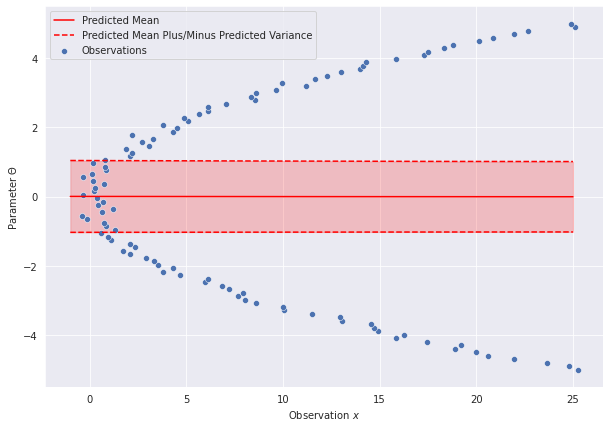

In [14]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [35]:
prngkey = jax.random.PRNGKey(20)
loss = losses.ReverseKL(joint_dist, use_reparameterisation=True)
optimiser = optimisers.Adam()
optimiser.fit(amortised_dist, loss, data, prngkey, verbose=True, num_samples=1000, max_iter=200)

Loss = 6.516937255859375
Loss = 44.87244415283203
Loss = 10.696911811828613
Loss = 47.54931640625
Loss = 14.705718994140625
Loss = 7.744267463684082
Loss = 16.994979858398438
Loss = 22.530487060546875
Loss = 22.194286346435547
Loss = 17.90283203125
Loss = 12.32119369506836
Loss = 8.556862831115723
Loss = 8.6553316116333
Loss = 11.550951957702637
Loss = 13.726943016052246
Loss = 13.084479331970215
Loss = 10.735231399536133
Loss = 8.758407592773438
Loss = 8.148648262023926
Loss = 8.68346881866455
Loss = 9.60151481628418
Loss = 10.243401527404785
Loss = 10.293107986450195
Loss = 9.764581680297852
Loss = 8.915278434753418
Loss = 8.128692626953125
Loss = 7.745418548583984
Loss = 7.863372802734375
Loss = 8.242426872253418
Loss = 8.463699340820312
Loss = 8.267195701599121
Loss = 7.762409687042236
Loss = 7.29686975479126
Loss = 7.137948036193848
Loss = 7.29245138168335
Loss = 7.565192699432373
Loss = 7.730387210845947
Loss = 7.670767784118652
Loss = 7.42389440536499
Loss = 7.138340950012207
Lo

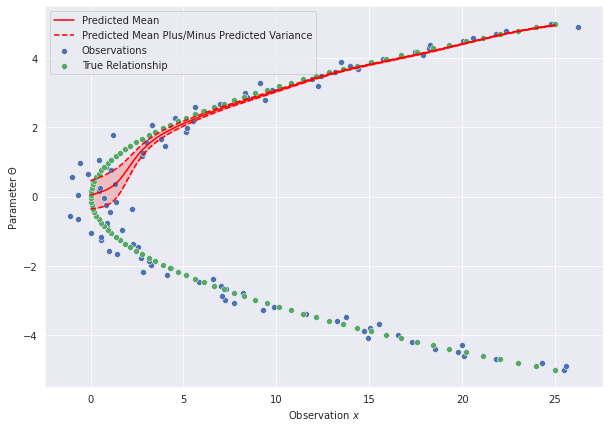

In [36]:
x_plt = jnp.linspace(0,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta, model)

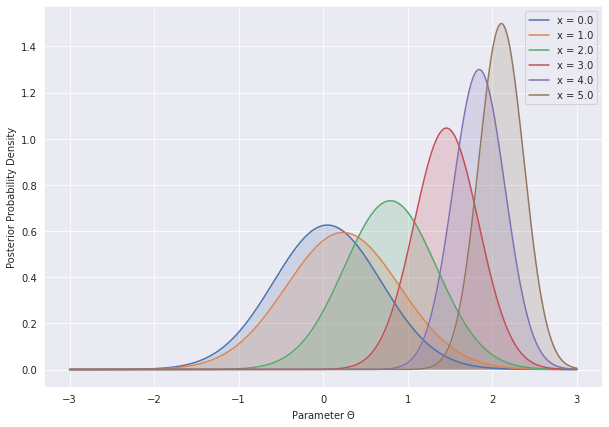

In [37]:
x_vals = [0, 1, 2, 3, 4, 5]
plot_posteriors(amortised_dist, x_vals)

# Linear Regression

In [94]:
prngkey = jax.random.PRNGKey(10)
approx_dist = approx.Gaussian(ndim)
preprocessing = amortised.Preprocessing.range_scaling(data)
amortised_dist = amortised.LinearRegression(approx_dist, ndim, prngkey, order=20, preprocessing=preprocessing)

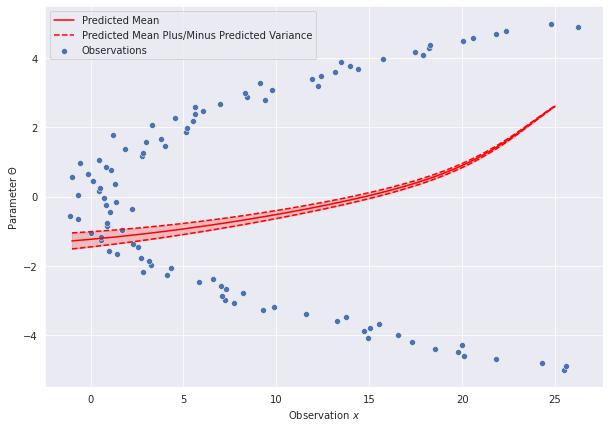

In [95]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [96]:
amortised_dist.initialise(data)

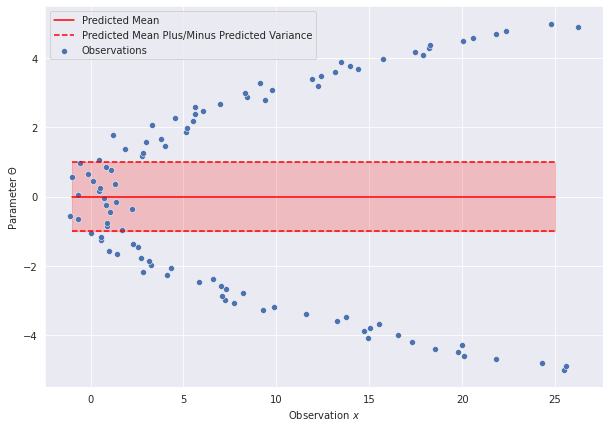

In [97]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [98]:
prngkey = jax.random.PRNGKey(42)
loss = losses.ReverseKL(joint_dist, use_reparameterisation=True)
optimiser = optimisers.Adam()
optimiser.fit(amortised_dist, loss, data, prngkey, verbose=True, num_samples=1000, max_iter=200)

Loss = 59.435672760009766
Loss = 128.6910400390625
Loss = 56.883602142333984
Loss = 60.76547622680664
Loss = 60.57522964477539
Loss = 58.06157684326172
Loss = 53.54672622680664
Loss = 48.17335510253906
Loss = 44.73500061035156
Loss = 46.13175582885742
Loss = 49.40176773071289
Loss = 48.22307205200195
Loss = 43.17081832885742
Loss = 37.78675842285156
Loss = 34.016357421875
Loss = 31.749900817871094
Loss = 30.03757095336914
Loss = 28.096158981323242
Loss = 25.598100662231445
Loss = 22.594451904296875
Loss = 19.392189025878906
Loss = 16.45685577392578
Loss = 14.28992748260498
Loss = 13.22613525390625
Loss = 13.196332931518555
Loss = 13.688199043273926
Loss = 14.111220359802246
Loss = 14.255900382995605
Loss = 14.312980651855469
Loss = 14.543560028076172
Loss = 15.04637622833252
Loss = 15.758285522460938
Loss = 16.555286407470703
Loss = 17.329843521118164
Loss = 18.01698112487793
Loss = 18.59014892578125
Loss = 19.048337936401367
Loss = 19.40529441833496
Loss = 19.68288230895996
Loss = 19.

KeyboardInterrupt: 

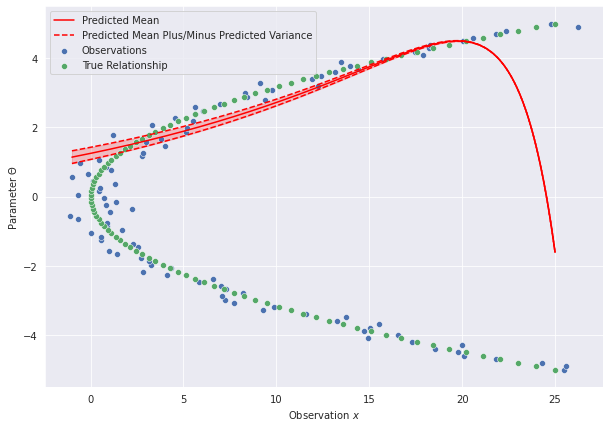

In [99]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta, model)

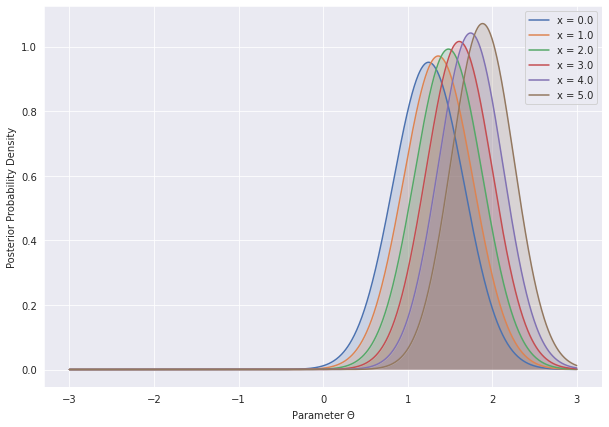

In [100]:
x_vals = [0, 1, 2, 3, 4, 5]
plot_posteriors(amortised_dist, x_vals)